In [24]:
# grid search best parameters for the vaccinations incorporation 

 
# vaccination_inflation: (0, 1)
# vaccination_low: (1.0, 1.2)
# vaccination_high: (1.25, 1.4)

# peak2_idx: [350, 700]
# peak2_inflation: (0, 1) 
# peak2_low: (1.0, 1.2)
# peak2_high: (1.25, 1.4)


In [4]:
import matplotlib.pyplot as plt 
import pandas as pd
def get_true_daily_deaths(simulation_end_date = '2021-12-31'):
    
    # Step 1: Read the CSV file into a DataFrame
    true_deaths_df = pd.read_csv('..\\data\\time_series_covid19_deaths_US.csv')

    # Step 2: Drop unnecessary columns
    columns_to_drop = ['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State', 
                    'Country_Region', 'Lat', 'Long_', 'Combined_Key', 'Population']
    true_deaths_df.drop(columns=columns_to_drop, inplace=True) 
    

    # Step 3: Sum death counts across all states for each date
    true_deaths_df = true_deaths_df.transpose()  # Transpose DataFrame 
    true_deaths_df['total_deaths'] = true_deaths_df.sum(axis=1)  
    
    # Step 4: Drop not necessaary columns  
    true_deaths_df = true_deaths_df.iloc[:, [-1]] 

    # Step 5: Filter data to include only dates starting from 2020-02-05 and ending at 2020-12-31   
    true_deaths_df.index = pd.to_datetime(true_deaths_df.index, format='%m/%d/%y')
    true_deaths_df = true_deaths_df.loc['2020-02-04':simulation_end_date]
    # print(true_deaths_df.head())
    daily_deaths = true_deaths_df['total_deaths'].diff()  # get daily deaths from accum deaths 

    return daily_deaths[1:]

# true_deaths = get_true_daily_deaths("2021-07-31").values 

# # plot true data    
# plt.figure(figsize=(10, 6)) 
# plt.plot(range(len(true_deaths)), true_deaths) 
# plt.xlabel('Date')
# plt.ylabel('Daily Deaths')
# plt.title('True Deaths Over Time')
# plt.xticks(rotation=45) 
# plt.grid(True)
# plt.show()
# plt.show()

In [5]:
from region_model import RegionModel
from simulation import run
from run_simulation import load_best_params_from_file, convert_mean_params_to_params_dict
from utils import str_to_date, remove_space_region

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
import numpy as np 

 
class MyEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, country, region, subregion, skip_hospitalizations, best_params_type, best_params_dir,
                 start_date="", end_date="", skip_vaccinations=False,
                 vaccination_inflation=0.1, vaccination_low=1.01, vaccination_high=1.28,
                 use_peak2=True, peak2_idx=400, peak2_inflation=0.1, peak2_low=1.01, peak2_high=1.28 
                 ): 
        # default parameters 
        self.country = country
        self.region = region 
        self.subregion = subregion     
        self.skip_hospitalizations = skip_hospitalizations
        self.best_params_type = best_params_type
        self.best_params_dir = best_params_dir
        self.start_date = start_date
        self.end_date = end_date  
         
 
        if self.country != 'US' and not self.region:
            self.region = 'ALL'

        best_params_type = self.best_params_type
        assert best_params_type in ['mean', 'median', 'top', 'top10'], best_params_type
        # print("Check best_params_dir: " + self.best_params_dir)  
        
        # Load parameters from file
        best_params = load_best_params_from_file(self.best_params_dir, self.country, self.region, self.subregion)
        # print("self.start_date", self.start_date, type(self.start_date))
        # print("self.end_date", self.end_date, type(self.end_date))
        if self.start_date:
            self.simulation_start_date = str_to_date(self.start_date) 
        else:
            self.simulation_start_date = str_to_date(best_params['first_date'])
        if self.end_date:
            self.simulation_end_date = str_to_date(self.end_date) 
        else:
            self.simulation_end_date = str_to_date(best_params['projection_end_date'])
        self.simulation_create_date = str_to_date(best_params['date']) 
        self.region_params = {'population' : best_params['population']}
        # mean_params, median_params, top_params, or top10_params
        params_type_name = f'{best_params_type}_params' 
        # print('best params type:', best_params_type)
        params_dict = convert_mean_params_to_params_dict(best_params[params_type_name]) 

        # create model 
        self.region_model = RegionModel(self.country, self.region, self.subregion,
            self.simulation_start_date, self.simulation_create_date, self.simulation_end_date, self.region_params,
            compute_hospitalizations=(not self.skip_hospitalizations))  
        
         
        # set parameters to be searched 
        self.region_model.vaccination_inflation = vaccination_inflation 
        self.region_model.vaccination_low  = vaccination_low  
        self.region_model.vaccination_high  = vaccination_high  
        self.region_model.peak2_idx  = peak2_idx  
        self.region_model.peak2_inflation  = peak2_inflation  
        self.region_model.peak2_low  = peak2_low  
        self.region_model.peak2_high = peak2_high 
        self.region_model.skip_vaccinations = skip_vaccinations
        self.region_model.use_peak2 = use_peak2 
        self.region_model.wrap_model = True
        # print('================================')
        # print(self.region_model)
        # print('================================')
        # print('Parameters:')
        # for param_name, param_value in params_dict.items():
        #     print(f'{param_name:<25s} : {param_value}')

        # Add params to region_model
        params_tups = tuple(params_dict.items())
        self.region_model.init_params(params_tups)

    def fit(self): 
        # update model parameters  
        # print("===============================================")
        # print("vaccination_inflation:", self.vaccination_inflation)
        # print("vaccination_low:", self.vaccination_low)
        # print("vaccination_high:", self.vaccination_high)
        # print("vaccination_high:", self.vaccination_high)
        # print("vaccination_high:", self.vaccination_high)
        return self 

    def predict(self):
        # print('--------------------------')
        # print('Running simulation...')
        # print('--------------------------')
        # Run simulation
        dates, infections, hospitalizations, deaths = run(self.region_model)

        """
        The following are lists with length N, where N is the number of days from
            simulation_start_date to simulation_end_date.

        dates            : datetime.date objects representing day i
        infections       : number of new infections on day i
        hospitalizations : occupied hospital beds on day i
        deaths           : number of new deaths on day i
        """
        assert len(dates) == len(infections) == len(hospitalizations) == len(deaths)  
        return deaths.tolist()
 

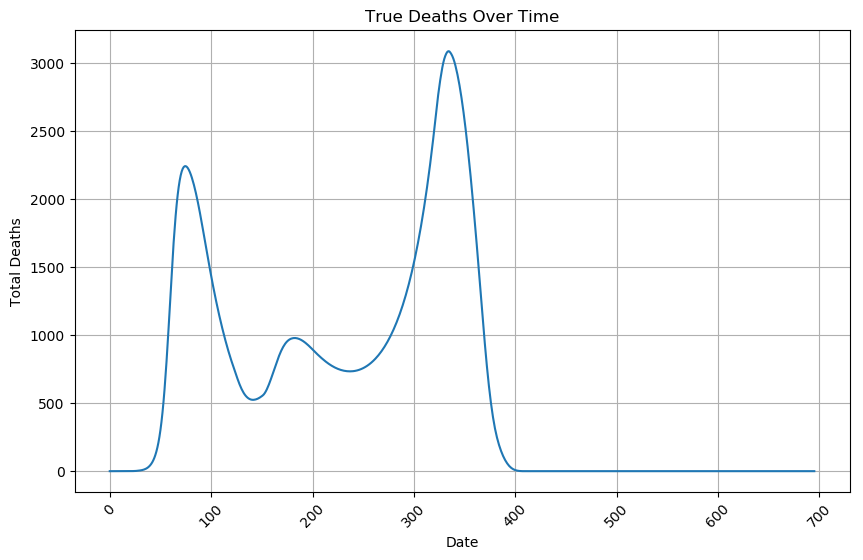

In [3]:
# default parameters 
country = 'US'
region = ''
subregion = ''
skip_hospitalizations = False 
best_params_type = 'mean'
best_params_dir = 'best_params/latest'
simulation_end_date = "2021-12-31" 

my_estimator = MyEstimator(country, region, subregion, skip_hospitalizations, best_params_type, best_params_dir, '', simulation_end_date) 
deaths_predict = my_estimator.predict()
 
import pandas as pd 
import matplotlib.pyplot as plt 

# plot simulated data    
plt.figure(figsize=(10, 6)) 
plt.plot(range(len(deaths_predict)), deaths_predict) 
plt.xlabel('Date')
plt.ylabel('Total Deaths')
plt.title('True Deaths Over Time')
plt.xticks(rotation=45) 
plt.grid(True)
plt.show()
plt.show()

In [8]:
# Step 4: Set up and execute grid search

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform 
import itertools

def custom_loss(truth, preds):
    truth_logs = np.array(truth) 
    preds_logs = np.array(preds)
    numerator = np.sum(np.square(truth_logs - preds_logs))  
    loss = np.sum(np.sqrt(numerator / len(truth)))  
    return loss 

def plot_true_predict_deaths(truth, preds):
    # plot true data    
    plt.figure(figsize=(10, 6)) 
    plt.plot(range(len(truth)), truth, label = "True") 
    plt.plot(range(len(preds)), preds, label = "preds")  
    plt.xlabel('Date')
    plt.ylabel('Daily Deaths')
    plt.title('True Deaths Over Time')
    plt.xticks(rotation=45) 
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.show()

In [11]:
 
    
# default parameters 
country = 'US'
region = ''
subregion = ''
skip_hospitalizations = False 
best_params_type = 'mean'
best_params_dir = 'best_params/latest'
simulation_end_date = "2021-07-31" 
use_peak2 = True
 
# parameters to be searched 
param_grid = {
    'vaccination_inflation': [0.1, 0.15, 0.2],
    'vaccination_low': [1.0, 1.05, 1.1],
    'vaccination_high': [1.1, 1.5, 1.2, 1.5, 1.3, 1.35],
    'peak2_idx': [390, 400],  
    'peak2_inflation': [0.1, 0.2, 0.3, 0.4],
    'peak2_low': [1.0, 1.1, 1.2],
    'peak2_high': [1.1, 1.5, 1.2, 1.5, 1.3, 1.35],
}  
# Generate all combinations of parameters
param_combinations = list(itertools.product(
    param_grid['vaccination_inflation'],
    param_grid['vaccination_low'],
    param_grid['vaccination_high'],
    param_grid['peak2_idx'],
    param_grid['peak2_inflation'],
    param_grid['peak2_low'],
    param_grid['peak2_high']
))

best_score = float('inf')
best_params = None
 
Y = true_deaths.tolist()  

print("param_combinations length", len(param_combinations))

# Iterate over all parameter combinations
for params in param_combinations:
    # print("params:", params)
    vaccination_inflation, vaccination_low, vaccination_high, peak2_idx, peak2_inflation, peak2_low, peak2_high = params 
    # Create the model  
    estimator = MyEstimator(country, region, subregion, skip_hospitalizations, best_params_type, best_params_dir, '', simulation_end_date, False,  
                            vaccination_inflation, vaccination_low, vaccination_high, 
                            use_peak2, peak2_idx, peak2_inflation, peak2_low, peak2_high)   
    
    # Evaluate the estimator
    deaths_predict = estimator.predict()
    # print(deaths_predict[-100:])
    score = custom_loss(true_deaths, deaths_predict)

    # plot the estimate 
    # plot_true_predict_deaths(true_deaths, deaths_predict)
    print("=================================================")
    print("score:", score) 
    print("Best score:", best_score)
    print("Best params:", best_params)
    
    # Update the best parameters if the current score is better
    if score < best_score:
        best_score = score
        best_params = params

print("Best Parameters:", best_params)
print("Best Score:", best_score)
 

param_combinations length 7776
score: 741.1717248663568
Best score: inf
Best params: None
score: 741.1717248663568
Best score: 741.1717248663568
Best params: (0.1, 1.0, 1.1, 390, 0.1, 1.0, 1.1)
score: 741.1717248663568
Best score: 741.1717248663568
Best params: (0.1, 1.0, 1.1, 390, 0.1, 1.0, 1.1)
score: 741.1717248663568
Best score: 741.1717248663568
Best params: (0.1, 1.0, 1.1, 390, 0.1, 1.0, 1.1)
score: 741.1717248663568
Best score: 741.1717248663568
Best params: (0.1, 1.0, 1.1, 390, 0.1, 1.0, 1.1)
score: 741.1717248663568
Best score: 741.1717248663568
Best params: (0.1, 1.0, 1.1, 390, 0.1, 1.0, 1.1)
score: 741.1717248663568
Best score: 741.1717248663568
Best params: (0.1, 1.0, 1.1, 390, 0.1, 1.0, 1.1)
score: 741.1717248663568
Best score: 741.1717248663568
Best params: (0.1, 1.0, 1.1, 390, 0.1, 1.0, 1.1)
score: 741.1717248663568
Best score: 741.1717248663568
Best params: (0.1, 1.0, 1.1, 390, 0.1, 1.0, 1.1)
score: 741.1717248663568
Best score: 741.1717248663568
Best params: (0.1, 1.0,

KeyboardInterrupt: 

In [4]:
   
# default parameters 
country = 'US'
region = ''
subregion = ''
skip_hospitalizations = False 
best_params_type = 'mean'
best_params_dir = 'best_params/latest'
simulation_end_date = "2021-7-31" 
use_peak2 = False

# parameters to be searched 
param_grid = {
    'vaccination_inflation': [0.1, 0.15, 0.2],
    'vaccination_low': [1.0, 1.05, 1.1],
    'vaccination_high': [1.1, 1.5, 1.2, 1.5, 1.3, 1.35],
    # 'peak2_idx': [390, 400],  
    # 'peak2_inflation': [0.1, 0.2, 0.3, 0.4],
    # 'peak2_low': [1.0, 1.1, 1.2],
    # 'peak2_high': [1.1, 1.5, 1.2, 1.5, 1.3, 1.35],
}   
# Generate all combinations of parameters
param_combinations = list(itertools.product(
    param_grid['vaccination_inflation'],
    param_grid['vaccination_low'],
    param_grid['vaccination_high'],
    # param_grid['peak2_idx'],
    # param_grid['peak2_inflation'],
    # param_grid['peak2_low'],
    # param_grid['peak2_high']
))

best_score = float('inf')
best_params = None
 
Y = get_true_daily_deaths(simulation_end_date).tolist()  

print("param_combinations length", len(param_combinations))

# Iterate over all parameter combinations
for params in param_combinations:
    # print("params:", params)
    # vaccination_inflation, vaccination_low, vaccination_high, peak2_idx, peak2_inflation, peak2_low, peak2_high = params 
    vaccination_inflation, vaccination_low, vaccination_high = params 
    # Create the model  
    # estimator = MyEstimator(country, region, subregion, skip_hospitalizations, best_params_type, best_params_dir, '', simulation_end_date, False,
    #                         vaccination_inflation, vaccination_low, vaccination_high, use_peak2,
    #                         peak2_idx, peak2_inflation, peak2_low, peak2_high)   
    estimator = MyEstimator(country, region, subregion, skip_hospitalizations, best_params_type, best_params_dir, '', simulation_end_date, False,
                            vaccination_inflation, vaccination_low, vaccination_high, use_peak2)   
    
    
    # Evaluate the estimator
    deaths_predict = estimator.predict()
    # print(deaths_predict[-100:])
    score = custom_loss(true_deaths, deaths_predict)

    # plot the estimate 
    # plot_true_predict_deaths(true_deaths, deaths_predict)
    print("=================================================")
    print("score:", score) 
    print("Best score:", best_score)
    print("Best params:", best_params)
    
    # Update the best parameters if the current score is better
    if score < best_score:
        best_score = score
        best_params = params

print("Best Parameters:", best_params)
print("Best Score:", best_score) 

param_combinations length 54
score: 741.1717248663568
Best score: inf
Best params: None
score: 699.0315012766355
Best score: 741.1717248663568
Best params: (0.1, 1.0, 1.1)
score: 729.6377705029573
Best score: 699.0315012766355
Best params: (0.1, 1.0, 1.5)
score: 699.0315012766355
Best score: 699.0315012766355
Best params: (0.1, 1.0, 1.5)
score: 718.6462431258443
Best score: 699.0315012766355
Best params: (0.1, 1.0, 1.5)
score: 713.4092008442896
Best score: 699.0315012766355
Best params: (0.1, 1.0, 1.5)
score: 708.8778012002313
Best score: 699.0315012766355
Best params: (0.1, 1.0, 1.5)
score: 673.5154566534072
Best score: 699.0315012766355
Best params: (0.1, 1.0, 1.5)
score: 698.2314595145532
Best score: 673.5154566534072
Best params: (0.1, 1.05, 1.5)
score: 673.5154566534072
Best score: 673.5154566534072
Best params: (0.1, 1.05, 1.5)
score: 688.6171033874228
Best score: 673.5154566534072
Best params: (0.1, 1.05, 1.5)
score: 684.2741912180622
Best score: 673.5154566534072
Best params: (

1.2


c:\Users\DELL\AppData\Local\Programs\Python\Python37-32\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\DELL\AppData\Local\Programs\Python\Python37-32\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\DELL\AppData\Local\Programs\Python\Python37-32\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\Users\DELL\AppData\Local\Programs\Python\Python37-32\lib\site-packages\matplotli

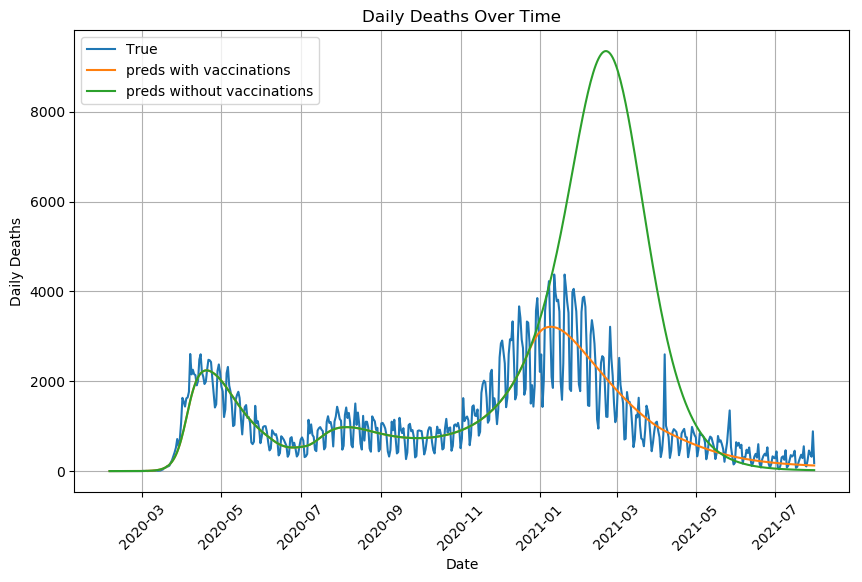

loss = 454.8546968780743


In [37]:
## use method 3 
# best params: (0.1, 1.1, 1.4, 390, 0.1, 1.2, 1.25) 
# best params (2021-07-31): (0.1, 1.1, 1.35, 400, 0.1, 1.0, 1.25)  
# best params (2021-07-31): (0.15, 1.1, 1.2, 400, 0.1, 1.2, 1.1) 
# best params (2021-07-31; no peak2): (0.2, 1.1, 1.3)
# default parameters 
country = 'US'
region = ''
subregion = ''
skip_hospitalizations = False 
best_params_type = 'mean'
best_params_dir = 'best_params/latest'
simulation_end_date = "2021-7-31" 
# (self, country, region, subregion, skip_hospitalizations, best_params_type, best_params_dir,
#                  start_date="", end_date="", skip_vaccinations=False,
#                  vaccination_inflation=0.1, vaccination_low=1.01, vaccination_high=1.28,
#                  use_peak2=True, peak2_idx=400, peak2_inflation=0.1, peak2_low=1.01, peak2_high=1.28 
#                  ): 
# # set best found parameters 
params =   (0.15, 1.1, 1.2, 400, 0.1, 1.2, 1.1) 
vaccination_inflation, vaccination_low, vaccination_high, peak2_idx, peak2_inflation, peak2_low, peak2_high = params  
# create model  
estimator = MyEstimator(country, region, subregion, skip_hospitalizations, best_params_type, best_params_dir, '', simulation_end_date, False,
                        vaccination_inflation, vaccination_low, vaccination_high, 
                        True, peak2_idx, peak2_inflation, peak2_low, peak2_high)  
# params = (0.2, 1.1, 1.3)
# vaccination_inflation, vaccination_low, vaccination_high = params  
# estimator = MyEstimator(country, region, subregion, skip_hospitalizations, best_params_type, best_params_dir, '', simulation_end_date, False,
#                         vaccination_inflation, vaccination_low, vaccination_high, 
#                         True, peak2_idx, peak2_inflation, peak2_low, peak2_high)  
# predict daily deaths 
true_deaths = get_true_daily_deaths(simulation_end_date)
deaths_predict = estimator.predict() 
print(estimator.region_model.peak2_low)
score = custom_loss(true_deaths, deaths_predict)
 
# plot the estimate 
# plot_true_predict_deaths(true_deaths, deaths_predict) 
# plot true data    
plt.figure(figsize=(10, 6))  
orig_results = pd.read_csv('..\\results\\no_vaccinations.csv')
orig_preds =  orig_results['deaths']
dates = pd.to_datetime(orig_results.iloc[:, 0]) 
assert len(true_deaths) == len(deaths_predict) == len(orig_preds), print(len(true_deaths), len(deaths_predict), len(orig_preds))
plt.plot(dates, true_deaths, label = "True") 
plt.plot(dates, deaths_predict, label = "preds with vaccinations")  
plt.plot(dates, orig_preds, label = "preds without vaccinations")  
plt.xlabel('Date')
plt.ylabel('Daily Deaths')
plt.title('Daily Deaths Over Time') 
plt.xticks(rotation=45) 

plt.grid(True)
plt.legend() 
plt.savefig("..//results//vaccination_incorporation.png")
plt.show()
print("loss =", score)

In [34]:
dates

0      2020-02-05
1      2020-02-06
2      2020-02-07
3      2020-02-08
4      2020-02-09
          ...    
538    2021-07-27
539    2021-07-28
540    2021-07-29
541    2021-07-30
542    2021-07-31
Name: # dates, Length: 543, dtype: object

In [ ]:
# # Step 4: Set up and execute grid search

# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from scipy.stats import uniform 
 
# def custom_loss(truth, preds):
#     truth_logs = np.array(truth) 
#     preds_logs = np.array(preds)
#     numerator = np.sum(np.square(truth_logs - preds_logs))
#     loss = np.sum(np.sqrt(numerator / len(truth)))  
#     return loss 


# # default parameters 
# country = 'US'
# region = ''
# subregion = ''
# skip_hospitalizations = False 
# best_params_type = 'mean'
# best_params_dir = 'best_params/latest'
# simulation_end_date = "2021-12-31" 

# # parameters to be searched 
# # param_grid = {
# #     'vaccination_inflation': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
# #     'vaccination_low': [1.0, 1.1, 1.2],
# #     'vaccination_high': [1.25, 1.3, 1.35, 1.4],
# #     'peak2_idx': list(range(350, 500, 10)),  
# #     'peak2_inflation': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
# #     'peak2_low': [1.0, 1.1, 1.2],
# #     'peak2_high': [1.25, 1.3, 1.35, 1.4]
# # }  

# param_grid = {
#     'vaccination_inflation': [0.1],
#     'vaccination_low': [1.0, 1.1, 1.2],
#     'vaccination_high': [1.25],
#     'peak2_idx': [400],  
#     'peak2_inflation': [0.1],
#     'peak2_low': [1.0],
#     'peak2_high': [1.25]
# }  
# # Generate all combinations of parameters
# param_combinations = list(itertools.product(
#     param_grid['vaccination_inflation'],
#     param_grid['vaccination_low'],
#     param_grid['vaccination_high'],
#     param_grid['peak2_idx'],
#     param_grid['peak2_inflation'],
#     param_grid['peak2_low'],
#     param_grid['peak2_high']
# ))

# my_estimator = MyEstimator(country, region, subregion, skip_hospitalizations, best_params_type, best_params_dir, '', simulation_end_date)
 
# search_model = GridSearchCV(estimator=my_estimator, param_grid=param_grid, scoring=custom_loss, cv=3, n_jobs=None, verbose=2)
# X = [1]*len(true_deaths)
# Y = true_deaths.tolist()
# search_model.fit(X, Y)
# # Get the best parameters and estimator
# print("Best parameters found: ", search_model.best_params_)
# print("Best estimator found: ", search_model.best_estimator_)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from scipy.stats import uniform 

# def custom_loss(truth, preds):
#     truth_logs = np.array(truth) 
#     preds_logs = np.array(preds)
#     numerator = np.sum(np.square(truth_logs - preds_logs))
#     loss = np.sum(np.sqrt(numerator / len(truth)))
#     print(loss)  
#     return loss 
 

# # default parameters 
# country = 'US'
# region = ''
# subregion = ''
# skip_hospitalizations = False 
# best_params_type = 'mean'
# best_params_dir = 'best_params/latest'
# simulation_end_date = "2021-12-31" 

# # parameters to be searched 
# # Create a parameter distribution
# param_distributions = {
#     'vaccination_inflation': uniform(0, 1),         # uniform distribution between 0 and 1
#     'vaccination_low': uniform(1.0, 0.2),           # uniform distribution between 1.0 and 1.2
#     'vaccination_high': uniform(1.25, 0.15),        # uniform distribution between 1.25 and 1.4
#     'peak2_idx': uniform(350, 350),                 # uniform distribution between 350 and 700
#     'peak2_inflation': uniform(0, 1),               # uniform distribution between 0 and 1
#     'peak2_low': uniform(1.0, 0.2),                 # uniform distribution between 1.0 and 1.2
#     'peak2_high': uniform(1.25, 0.15)               # uniform distribution between 1.25 and 1.4
# }

# my_estimator = MyEstimator(country, region, subregion, skip_hospitalizations, best_params_type, best_params_dir, '', simulation_end_date)
 
# # Create a RandomizedSearchCV object
# search_model = RandomizedSearchCV(my_estimator, param_distributions, n_iter=100, cv=3, scoring=custom_loss, random_state=42) 
 

# X = [1]*len(true_deaths)
# Y = true_deaths.tolist()
# search_model.fit(X, Y)
# # Get the best parameters and estimator
# print("Best parameters found: ", search_model.best_params_)
# print("Best estimator found: ", search_model.best_estimator_)

In [ ]:
# from sklearn.model_selection import GridSearchCV

# class MyModel(BaseEstimator, ClassifierMixin):
#     def __init__(self, start, length):
#         self.start = start 
#         self.length = length 
    
#     def fit(self):
#         return self
    
#     def predict(self):
#         results = range(self.start, self.start+self.length)
#         return list(results)
    
# def custom_loss(true, pred):
#     true_arr = np.array(true)
#     pred_arr = np.array(pred)
#     numerator = np.sum(np.square(true_arr - pred_arr))
#     loss = np.sum(np.sqrt(numerator / len(true)))
#     return loss 

# # Define the parameter grid
# param_grid = {
#     'start': range(0, 5),  # Range of start values
#     'length': range(1, 8)  # Range of length values
# }

# # Instantiate the grid search model
# length = 100
# X = [0]*length
# Y = list(range(0, length))
# model = MyModel(2, 4)
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=custom_loss, cv=3, n_jobs=-1, verbose=2)

# # Perform the grid search
# grid_search.fit(X, Y)

# # Get the best parameters and the best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Parameters:", best_params)
# print("Best Score:", best_score)

# # Recover the true data using the best parameters
# best_model = grid_search.best_estimator_
# recovered_data = best_model.predict({'start': best_params['start'], 'length': best_params['length']})
# print("Recovered Data:", recovered_data)
